In [1]:
# %% [markdown]
# # 沪深300指数纯因子组合构建
#
# > WIFA量化组，2019年春。
#
# 依据多因子模型，尝试对沪深300指数构建纯因子组合。
#
# 注：由于数据都已经保存在本地，
# 故代码中提取及保存数据的部分都暂时被注释了。


# %%

In [2]:
cd ..

/Users/james/Desktop/Projects/strategy


In [3]:
ls data/

AShareBalanceSheet.csv.bdc-downloading  H3_Data/
AShareCashFlow.csv.bdc-downloading      数据1.7z.bdc-downloading
AShareIncome.csv.bdc-downloading


In [39]:
from scipy.optimize import minimize
# from WindPy import *
# import WindPy as w                           # for data fetching.
import statsmodels.api as sm                 # for OLS result.
from statsmodels import regression           # for OLS.
import math                                  # math calculation.
import matplotlib.pyplot as plt              # specify "plt".
import seaborn as sns                        # for plotting.
import numpy as np                           # for numerical manipulation.
import pandas as pd                          # for wrapping csv file.
import os                                    # for getting working directory.
path = os.getcwd()
sns.set(style="darkgrid")                    # set seaborn style.
#plt.rcParams['font.sans-serif'] = ['SimHei']  # For displaying chinese.
plt.rcParams['axes.unicode_minus'] = False   # For displaying minus sign.
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #MAC中文显示

In [5]:
# %%
# # Import Wind Module for getting data.
# w.start()

# Step 1：因子数据库构建

In [6]:
# %% [markdown]
# 
#
# 因子数据分为**风格因子**和**风险因子**。
#
# 其中风格因子又分为大类因子和细分类因子，最终风格因子会由细分类因子合成。
#
# 风格因子共选取以下7个大类中的19个因子：
#
# - VALUE：EPS_TTM/P、BPS_LR/P、CFPS_TTM/P、SP_TTM/P
# - GROWTH：NetProfit_SQ_YOY、Sales_SQ_YOY、ROE_SQ_YOY
# - PROFIT：ROE_TTM、ROA_TTM
# - QUALITY：Debt2Asset、AssetTurnover、InvTurnover
# - MOMENTUM：Ret1M、Ret3M、Ret6M
# - VOLATILITY：RealizedVol_3M、RealizedVol_6M
# - LIQUIDITY：Turnover_ave_1M、Turnover_ave_3M
#
# 风险因子选取以下2个大类中的2个因子：
#
# - INDUSTRY：中信一级行业
# - SIZE：Ln_MarketValue

# %%

In [28]:
def get_factors_list():
    '''
    Return factor list. (str list)

    保存所需因子（万德）指标名。

        保存的字段名即万德金融API(此处使用WindPy)的指标字段名。

    其中"pct_chg_1m",
        "pct_chg_3m",
        "pct_chg_6m",
        "stdevry_3m",
        "stdevry_6m",
        不好从wsd中取。

    所以"pct_chg_1m", 
        "pct_chg_3m",   
        "pct_chg_6m"
        是根据pct_chg计算的。

    波动率提取要填开始区间和截止区间。（区间为近几个月）
    '''
    return [
        "pe_ttm", "pb_lf", "pcf_ncf_ttm", "ps_ttm",
        "yoyprofit", "yoy_or", "yoyroe", "roe_ttm2",
        "roa_ttm2", "debttoassets", "assetsturn", "invturn",
        "pct_chg_1m", "pct_chg_3m", "pct_chg_6m", "stdevry_3m",
        "stdevry_6m", "tech_turnoverrate20", "tech_turnoverrate60", "val_lnmv"
    ]

# %%
def get_large_factors_list():
    '''
    Return large factors list. (str list)

    保存大类因子指标名。
    '''
    return [
        'VALUE', 'GROWTH', 'PROFIT',
        'QUALITY', 'MOMENTUM', 'VOLATILITY',
        'LIQUIDITY', 'INDUSTRY', 'SIZE'
    ]


In [29]:
# %% [markdown]
# 由于数据限制和平台选择，最终确定的因子和最初选取的因子比较如下：
#
# 最初选取因子|最终确定因子|因子解释
# :--:|:--:|:--:
# EPS_TTM/P|PE_TTM|市盈率
# BPS_LR/P|PB_LF|指定日最新公告股东权益
# CFPS_TTM/P|PCF_NCF_TTM|市现率（现金净流量）
# SP_TTM/P|PS_TTM|市销率
# NetProfit_SQ_YOY|YOYPROFIT|净利润同比增长率
# Sales_SQ_YOY|YOY_OR|营业收入同比增长率
# ROE_SQ_YOY|YOYROE|净资产收益率同比增长率
# ROE_TTM|ROE_TTM2|净资产收益率
# ROA_TTM|ROA_TTM2|总资产净利率
# Debt2Asset|DEBTTOASSETS|资产负债率
# AssetTurnover|ASSETSTURN|总资产周转率
# InvTurnover|INVTURN|存货周转率
# Ret1M|PCT_CHG|涨跌幅
# Ret3M|PCT_CHG|涨跌幅
# Ret6M|PCT_CHG|涨跌幅
# RealizedVol_3M|STDEVRY|3月年化波动率
# RealizedVol_6M|STDEVRY|6月年化波动率
# Turnover_ave_1M|TECH_TURNOVERRATE20|20日平均换手率
# Turnover_ave_3M|TECH_TURNOVERRATE60|60日平均换手率
# 中信一级行业列表|INDUSTRY_SW|申万行业名称
# Ln_MarketValue|VAL_LNMV|对数市值

# %%


def get_hs300_stocks_list():
    '''
    Return hs300 stocks list. (pd.DataFrame)
    '''

    file_path = path + "/data/H3_Data/Raw_Data/hs300.csv"

    # If file already exist, load from disk.
    if os.path.isfile(file_path):
        hs300_data = pd.read_csv(open(
            file_path,
            'r',
            encoding="utf-8"
        ), index_col=[0])

    # If file doesn't exist yet, fetch from WindPy.
    # else:
    #     # Getting the stock list of HS300.
    #     hs300_stocks_list = list(w.wset(
    #         "sectorconstituent",
    #         "date=2019-02-20;windcode=000300.SH",  # base on recent date.
    #         usedf=True
    #     )[1]['wind_code'])

    #     hs300_data = pd.DataFrame(
    #         data=hs300_stocks_list,
    #         columns=["HS300"]
    #     )
    #     # Store to disk.
    #     hs300_data.to_csv(file_path)

    return list(hs300_data["HS300"])

# %%


def factor_data_fetching_and_storing(
    start="2005-01-01",
    end="2019-02-20"
):
    '''
    Parameters:
        start: start date (YYYY-MM-DD). (str)
        end: end date (YYYY-MM-DD). (str)
    Return:
        save Raw_Data to "/data/H3_Data/Raw_Data/" as csv.
    '''
    # # Import data from wind and store it as csv.
    # for factor in get_factors_list():
    #     # Get each factor data from Wind.
    #     factor_data = w.wsd(
    #         get_hs300_stocks_list(),
    #         factor,
    #         start,
    #         end,
    #         "Period=M",
    #         usedf=True  # use pandas dataframe.
    #     )[1]            # the result is a tuple and we only need [1].
    #     # Name the data file by it's factor string.
    #     file_path = path + "/data/H3_Data/Raw_Data/" + factor + ".csv"
    #     factor_data.to_csv(file_path)  # store data.


# %%
# factor_data_fetching_and_storing()

# %%


def sw_industry_data_fetching_and_storing():
    '''
    Return: save SHENWAN industry data to "/data/H3_Data/Raw_Data/" as csv.
    '''
    # industry_sw = w.wsd(
    #     get_hs300_stocks_list(),
    #     "industry_sw",
    #     "2019-02-20",
    #     "2019-02-20",  # set the start and end date as the same.
    #     "industryType=1;Period=M",
    #     usedf=True
    # )[1]
    # file_path = path + "/data/H3_Data/Raw_Data/industry_sw.csv"
    # industry_sw.to_csv(file_path)

# %%
# sw_industry_data_fetching_and_storing()

# %% [markdown]
#
# > （注：Ret1M, Ret3M, Ret6M皆由PCT_CHG合成；RealizedVol_3M, RealizedVol_6M皆由UNDERLYINGHISVOL_90D代替。）
# >
# > 数据来源为万德金融数据库，通过WindPy API获取。
# >
# > 其中“最终确定因子”列即为其万德指标字段名。
# >
# > （数据保存在“H3_Data” ("HS300 Data" 的缩写) 文件夹中，格式为CSV，直接用全小写的万德指标名命名。
# > 即 "<万德指标名>.csv"，如 "pe_ttm.csv"）
# >
# > 获取的原始数据储存在"H3_Data/Raw_Data"文件夹里。
#
# 数据格式如下：
#
# 行/列 | 股票代号（000001.SZ）
# :--|--:
# 交易日期（YYYYMMDD） | 相应因子暴露

# Step 2：因子数据处理

In [30]:
# %% [markdown]
# # Step 2：因子数据处理
# 
# > 对因子数据进行处理。

# %%


def get_data(
    factor_name, 
    category="Raw", 
    start_year="2009"
):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
        category: which category of data. (str)
            - "Raw"
            - "Processed"
            - "Neutralized"
        start_year: the year when data start. (str) 
    Return:
        forward-filled factor data. (pd.DataFrame)
            index: months. (np.int64)
            columns: stocks code list. (str)
    '''
    data = pd.read_csv(open(
        # Extract Raw_Data.
        path + "/data/H3_Data/" + category + "_Data/" + factor_name + ".csv",
        # read-only mode for data protection.
        'r',
        encoding="utf-8"
    ), index_col=[0])

    # Forward-fill nan to make quarter report fill the month.
    data.fillna(method='ffill', inplace=True)

    if factor_name == "industry_sw":
        pass

    else:
        # Composite-data's date is formated already.
        # There'll be a wired bug if you insist to format again. 
        # All of the date would be "1990-01-01". 
        if (category=="Raw") & (
            factor_name not in [
                "pct_chg_1m", 
                "pct_chg_3m", 
                "pct_chg_6m"
            ]
        ):
            # Make all date format in the same way.
            data.index = pd.to_datetime(data.index).strftime('%Y%m%d')
        data = data.loc[start_year+'0131' : '20190131']
    return data

# %%


def pct_chg_composition():
    '''
    Return: composite and store pct_chg_3m, pct_chg_6m factor data.
    '''
    # Turn percentage format from percent to decimal.
    pct_chg_data = get_data("pct_chg",start_year='2007')/100 + 1

    pct_chg_1m = pct_chg_data - 1
    pct_chg_3m = pct_chg_data.rolling(3).apply(lambda x: np.prod(x)) - 1
    pct_chg_6m = pct_chg_data.rolling(6).apply(lambda x: np.prod(x)) - 1

    for factor_data, factor_name in zip(
        [pct_chg_1m, pct_chg_3m, pct_chg_6m],
        ["pct_chg_1m", "pct_chg_3m", "pct_chg_6m"]
    ):
        factor_data.index = pd.to_datetime(
            factor_data.index
        ).strftime('%Y%m%d')

        factor_data.to_csv(
            path
            + "/data/H3_Data/Raw_Data/"
            + factor_name
            + ".csv"
        )

# %%
# pct_chg_composition()

# %%


def get_values(data):
    '''
    Parameter:
        data: input data. (pd.DataFrame)
    Return:
        a list of all values in data except nan. (list)
    '''
    # Collect all non-nan value into data_list.
    value_list = []
    for i in range(len(data.columns)):
        # is there a way to avoid loop?
        value_list += data.iloc[:, i].dropna().tolist()
    return value_list

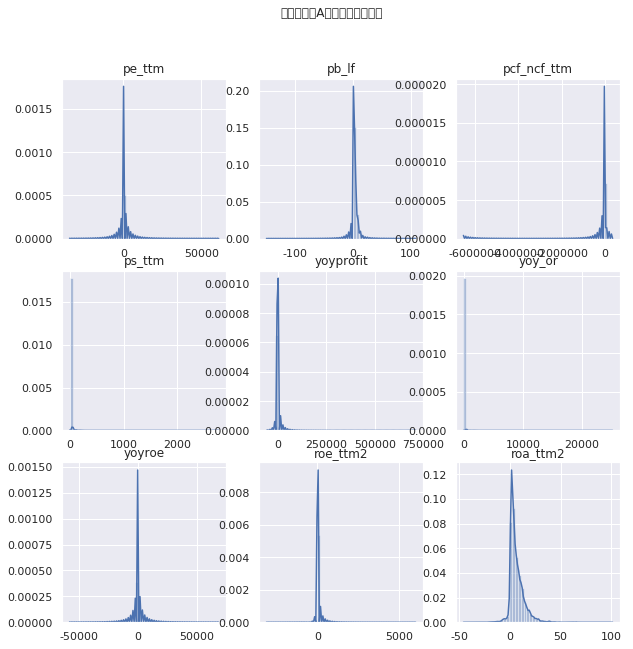

In [32]:
# %% [markdown]
# 如图为任取9个因子的沪深300的暴露数据在2005~2018年分布统计图。👇

# %%


def overview(
    source_data_function,
    title
):
    '''
    Parameters:
        source_data_function: 
            the function to get source data for plot. (function)
        title: 
            the title of the plot as well as the file. (str)
    Return: save a 3*3 histogram distribution plot of data.
    '''
    factors_list = get_factors_list()[:9]

    plt.figure(figsize=(10, 10))
    for i, factor in zip(
        range(len(factors_list)),
        factors_list
    ):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data=source_data_function(factor)
        ))
        plt.title(factor)

    plt.suptitle(title)
    plt.savefig(path + "/output/H3_Plots/" + title + ".png")

# %%
overview(
    source_data_function=get_data,  
    title="不同因子在A股的历史数据分布"
)

# %% [markdown]
# 从图中可以看出原始的因子数据都存在极差过大、分布非常不均匀的现象。
# 大多数数据集中于一个值附近，但是总体来看值域又非常广。
# 
# 过大或过小的数据都会影响到统计分析的结果，所以需要对数据进行处理。

## 填补缺失值
由于万德输出的当季度财务数据只在报告期有数据，而在该季度的其他月份没有数据，所以针对这个现象采用“**向前填充**”来填补缺失值。

In [34]:
#data.fillna(method = 'ffill', inplace = True)
#针对剩余的缺失数据，我们将在数据[标准化](##2.3标准化)处理后统一填充为零

## 2.2 去极值

In [ ]:

# 
# 去极值的方法采用调整因子值中的离群值至指定阈值的上下限，从而减小**离群值**和**极值**对统计的偏差。
# 
# 离群值的阈值上下限定义的方法主要有三种：
# 
# 1. MAD法
# 2. 3σ法
# 3. 百分位法
# 
# ### 2.2.1 MAD法 (Median Absolute Deviation)
# 
# 取因子的中位数，加减每个因子与该中位数的绝对偏差值的中位数乘上给定参数（此处经过调参设定默认为100倍）得到上下阈值。
# 
# 经过MAD法去极值后的因子数据概览如下：

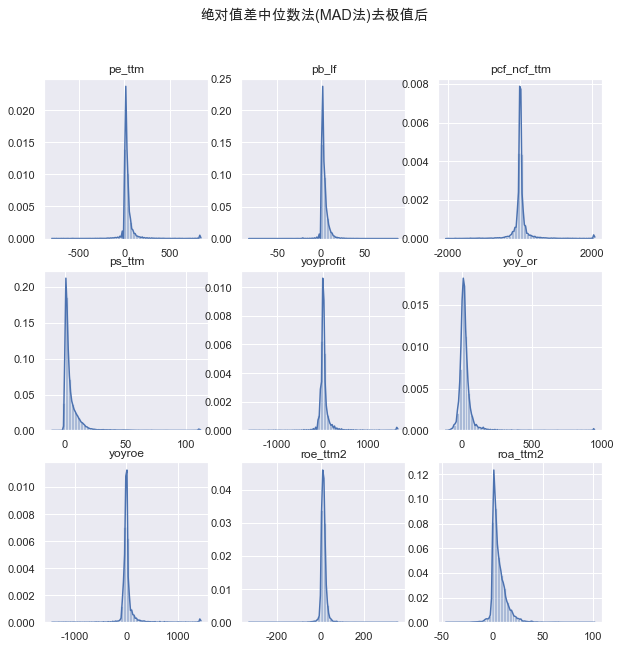

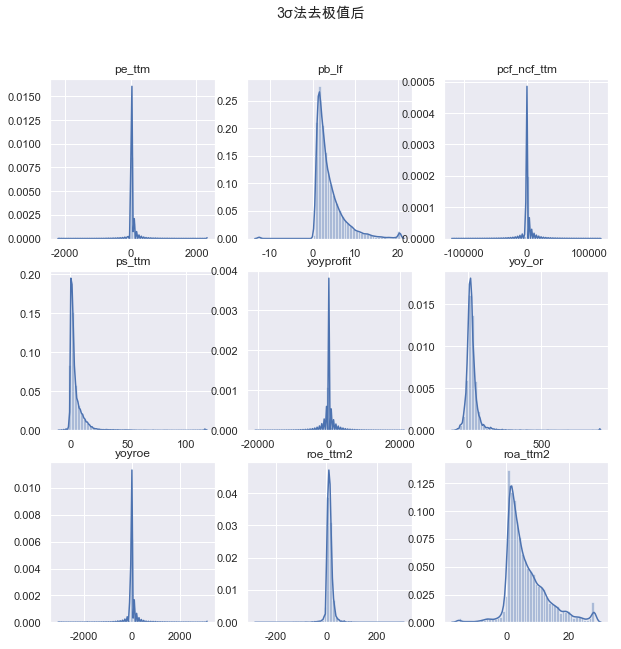

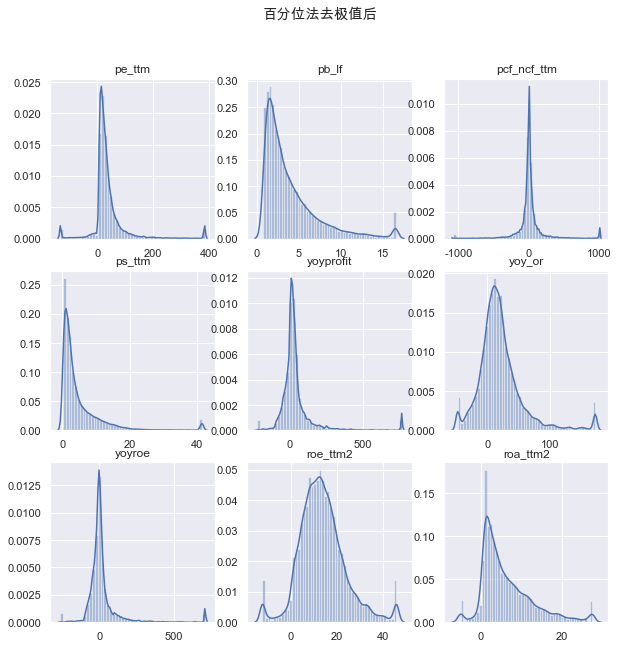

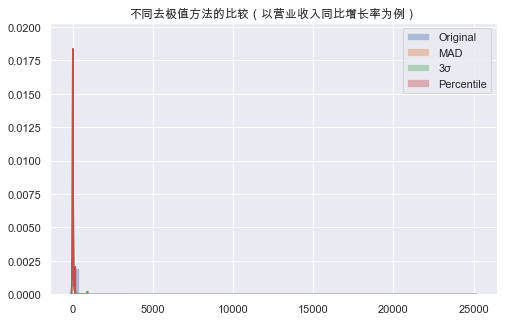

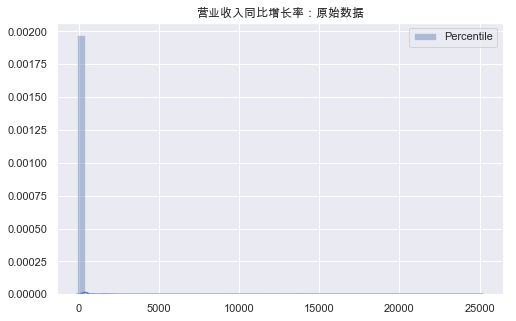

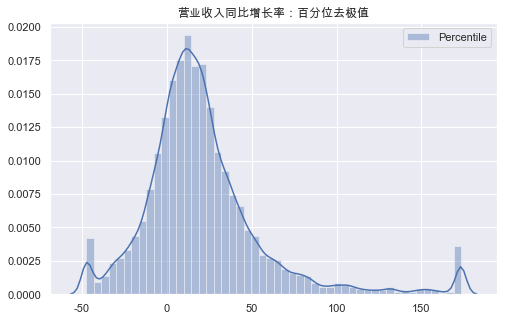

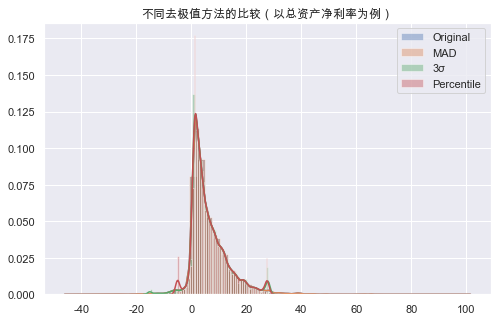

In [40]:
def MAD_filter(factor_name, n=60,start_year='2009'):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
        n: how many times new median. (int)
    Return:
        filtered data. (pd.DataFrame)
    '''
    data = get_data(factor_name,start_year=start_year)
    values = get_values(data)
    median = np.percentile(
        values,
        50
    )
    new_median = np.percentile(
        get_values(abs(data - median)), 50
    )
    min_range = median - n * new_median
    max_range = median + n * new_median
    return data.clip(min_range, max_range, axis=1)

# %%
overview(
    source_data_function=MAD_filter,
    title="绝对值差中位数法(MAD法)去极值后"
)

# %% [markdown]
# ### 2.2.2 3σ法
# 
# 取所有因子数据的标准差（即σ），偏离平均值给定参数（此处默认为三倍）标准差处设为上下阈值。
# 
# 经过3σ法去极值后的因子数据概览如下：

# %%


def three_sigma_filter(factor_name, n=3):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
        n: how many sigmas. (int)
    Return:
        filtered data. (pd.DataFrame)
    '''
    data = get_data(factor_name)
    values = get_values(data)
    min_range = np.mean(values) - n * np.std(values)
    max_range = np.mean(values) + n * np.std(values)
    return data.clip(min_range, max_range, axis=1)

# %%
overview(
    source_data_function=three_sigma_filter, 
    title="3σ法去极值后"
)

# %% [markdown]
# ### 2.2.3 百分位法
# 
# 取给定百分位作为上下阈值。（此处经过调参设定为下限1.5%，上限98.5%分位点）
# 
# 经过百分位法去极值后的因子数据概览如下：

# %%


def percentile_filter(factor_name, min=1.5, max=98.5):
    '''
    Parameters:
        factor_name: name of factors in Wind. (str)
        min: minimum percentage. (float)
        max: maximum percentage. (float)
    Return:
        filtered data. (pd.DataFrame)
    '''
    data = get_data(factor_name)
    values = get_values(data)
    min_range = np.percentile(values, min)
    max_range = np.percentile(values, max)
    return np.clip(data, min_range, max_range)


# %%
overview(
    source_data_function=percentile_filter, 
    title="百分位法去极值后"
)

# %% [markdown]
# ### 2.2.4 去极值研究。
# 
# 实际上，即使经过调参尽可能地使三种主流的去极值方法的结果互相接近，并不至于出现过于集中的阈值，仍然有可能出现非常显著不同的效果。
# 
# 以每股现金流为例，将原始数据和三种去极值的方法处理后的因子数据放在同一张图里，由于值域相差太大，甚至根本无法从图中找到不同的方法对应的图表。（如下图：分别采用三种去极值方法处理后的每股现金流数据与其原始数据图👇）

# %%


def huge_deviation_filter_method_comparison(factor_name):
    '''
    Return:
        save a histogram distribution plot of 
        a hugely deviated data for different filter method comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.distplot(get_values(
        data=get_data(factor_name)
    ), label="Original")
    sns.distplot(get_values(
        data=MAD_filter(factor_name)
    ), label="MAD")
    sns.distplot(get_values(
        data=three_sigma_filter(factor_name)
    ), label="3σ")
    sns.distplot(get_values(
        data=percentile_filter(factor_name)
    ), label="Percentile")
    plt.legend()
    plt.title("不同去极值方法的比较（以营业收入同比增长率为例）")
    plt.savefig(path + "/output/H3_Plots/Comparison" + factor_name + ".png")


# %%
huge_deviation_filter_method_comparison("yoy_or")

# %% [markdown]
# 究其原因，是其原始数据的集中度就非常高，以至于不同方法去极值计算出相差甚远的阈值。（如下图：全部A股样本期内每股现金流的密度分布图👇）

# %%


def huge_deviation_original_data():
    '''
    Return:
        save a histogram distribution plot of 
        original data with huge deviation.
    '''
    plt.figure(figsize=(8, 5))
    sns.distplot(get_values(
        data=get_data("yoy_or")
    ), label="Percentile")
    plt.legend()
    plt.title("营业收入同比增长率：原始数据")
    plt.savefig(path + "/output/H3_Plots/original yoy_or.png")


# %%
huge_deviation_original_data()

# %% [markdown]
# 所以经过百分位去极值后，尽管值域缩小了近100倍，但仍然非常集中。
# 
# 另外，这种离差过大的数据去极值的时候还会出现一个问题：造成阈值部分出现异常高的“虚假”数据，而这也是我们不愿意看到的。（如下图：每股现金流经过约束最严格的百分位去极值处理后的分布图👇）

# %%


def huge_deviation_filtered_data():
    '''
    Return:
        save a histogram distribution plot of 
        percentile-filtered data with huge deviation.
    '''
    plt.figure(figsize=(8, 5))
    sns.distplot(get_values(
        data=percentile_filter("yoy_or")
    ), label="Percentile")
    plt.legend()
    plt.title("营业收入同比增长率：百分位去极值")
    plt.savefig(path + "/output/H3_Plots/percentile filter yoy_or.png")


# %%
huge_deviation_filtered_data()

# %% [markdown]
# > 注意图中 [-50, 150] 处异常的“突起”。
# > 
# > 这是由于过多超出上下阈值的数据被迫调整为上下阈值，导致阈值处的数据分布特别密集。
# 
# 但在大多数情况下（数据分布相对均匀时，此处以ROE为例），各种方法以及原始数据相差不大。（如下图：资产周转率数据的原始数据及分别经过三种去极值方法处理后的分布图👇）

# %%


def filter_method_comparison():
    '''
    Return:
        save a histogram distribution plot of
        a normal data for different filter method comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.distplot(get_values(
        data=get_data("roa_ttm2")
    ), label="Original")
    sns.distplot(get_values(
        data=MAD_filter("roa_ttm2")
    ), label="MAD")
    sns.distplot(get_values(
        data=three_sigma_filter("roa_ttm2")
    ), label="3σ")
    sns.distplot(get_values(
        data=percentile_filter("roa_ttm2")
    ), label="Percentile")
    plt.legend()
    plt.title("不同去极值方法的比较（以总资产净利率为例）")
    plt.savefig(path + "/output/H3_Plots/Comparison(roa_ttm2).png")


# %%
filter_method_comparison()



-273.0


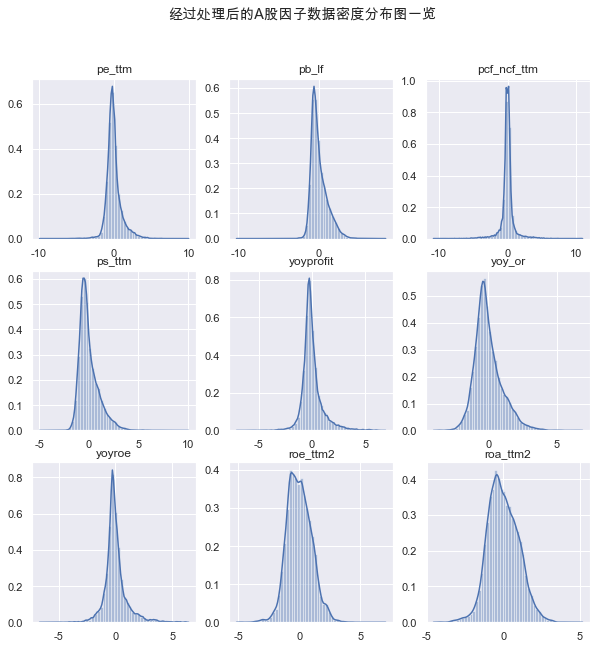

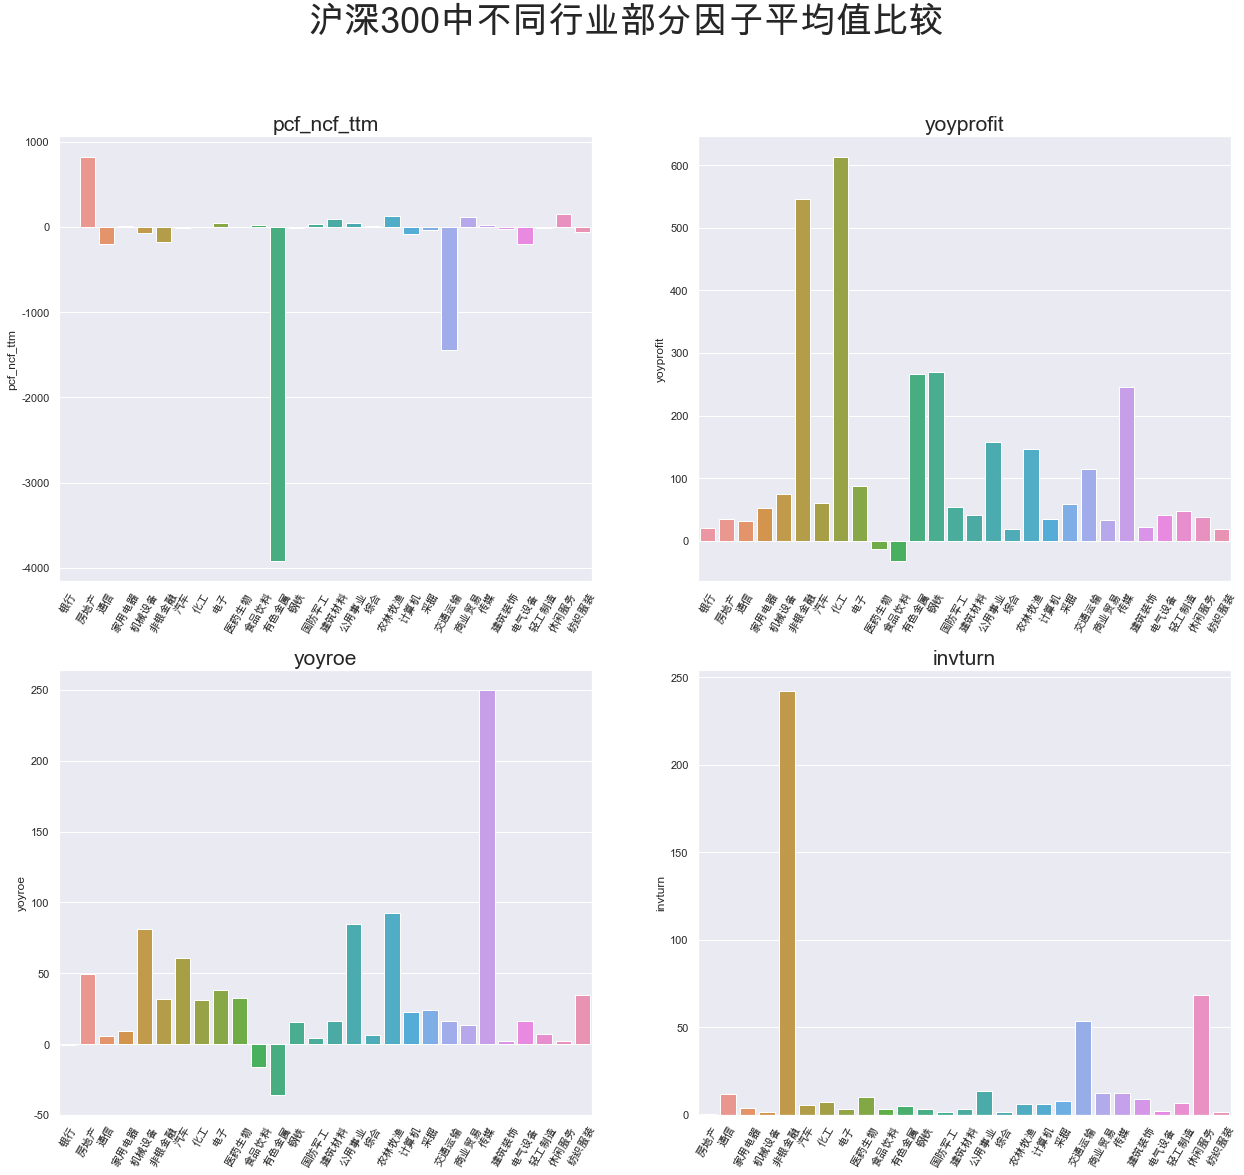

In [41]:
# %% [markdown]
# 经过比较研究，我们最终选取阈值选取相对最为合理，较少阈值异常“突起”，同时保留较宽值域的**参数值为60的MAD法**进行去极值处理。
# 
# ## 2.3 标准化
# 
# 标准化处理数据的目的就是去除其**量纲**。
# 
# 这样做可以使得：
# 
# - 数据更加集中
# - 不同数据之间可以互相比较和进行回归等
# 
# 主流的标准化的方法有两种：
# 
# 标准化方法|原理|优点|缺点
# :--|:--|:--:|:--:
# 对原始因子值标准化|减去均值后，除以标准差|保留更多信息|对数据分布有要求
# 对因子排序值标准化|因子排序值进行上述处理|适用性更广泛|非参数统计法
# 
# 它们都能使得数据的：
# 
# - 均值为0
# - 标准差为1
# 
# 由于已经对数据进行去极值处理，我们最终选取对原始因子值进行标准化(z-score)的方法进行标准化。
# 
# > 2.1， 2.2， 2.3的数据处理部分的：
# >
# > 数据保存在"H3_Data/Processed Data"文件夹里。

# %%
# Use z-score method to standardize.


def standardize(factor_name,start_year = '2009'):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
        start_year:the start_year the data start
    Return:
        standardized and Filtered (MAD) data. (pd.DataFrame)
    '''
    data = MAD_filter(factor_name,start_year = start_year)
    # data = data.fillna(0)
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std

# %%


def process_and_store_data(start_year):
    '''
    Return:
        save processed data in "/data/H3_Data/Processed Data/".
        ("processed" means filtered & standardized.)
    '''
    for factor in get_factors_list():
        processed_data = standardize(factor,start_year = start_year)
        file_path = path + "/data/H3_Data/Processed"+start_year+" Data/" + factor + ".csv"
        processed_data.to_csv(file_path)

# %%
# process_and_store_data('2007')
# process_and_store_data('2009')

# %% [markdown]
# 
# （如下图为经过去极值、标准化处理后的数据密度分布图一览👇）

# %%


def overview_processed_data():
    # Get an overview of processed data.
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        sns.distplot(get_values(
            data=get_data(get_factors_list()[i], category="Processed2009")
        ))
        plt.title(get_factors_list()[i])
    plt.suptitle("经过处理后的A股因子数据密度分布图一览")
    plt.savefig(path + "//output/H3_Plots/Processed Data.png")


# %%
overview_processed_data()

# %% [markdown]
# ## 2.4 中性化
# 
# 中性化的目的是剔除数据中多余的风险暴露。
# 
# 根据某些因子（指标）选股的时候，由于某些因子之间具有较强的相关性，故时常会有我们不希望看到的“**偏向**”，导致投资组合不够**分散**。
# 
# 例如以下四个指标：
# 
# - 市现率
# - 净利润同比增长率
# - 净资产收益率同比增长率
# - 存货周转率

# %%


def get_industry_list():
    '''
    Return:
        industry list in HS300 stocks list.
    '''
    return list(get_data("industry_sw").iloc[:, 0].unique())

# %%


def industry_comparison(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        average factor value of each industries. (pd.DataFrame)
            index: industry. (str)
            columns: factor name. (str)
    '''
    # All industry in HS300.
    # Use certain factor data for comparison example between industry.
    compare_data = get_data(factor_name, start_year='2009')
    compare_industry = pd.DataFrame(
        index=get_industry_list(),
        columns=[factor_name]
    )
    for industry in get_industry_list():
        industry_stock_code_list = list(get_data("industry_sw")[
            get_data("industry_sw").iloc[:, 0] == industry  
        ].index)
        # Some industry is not in HS300.
        try:
            industry_data = compare_data[industry_stock_code_list]
            compare_industry.loc[
                industry, factor_name
            ] = np.mean(np.mean(industry_data))
        except:
            continue
    compare_industry.dropna(inplace=True)
    return compare_industry

# %% [markdown]
# 沪深300股票指数中共包含17个行业（根据申万一级行业分类），分别统计沪深300指数中各行业以上四个指标的平均值，结果如下图所示👇。

# %%


def plot_industry_comparison():
    '''
    Return:
        save a 2*2 plot of average factor of each industries, 
        which are all siginificantly different. 
    '''
    # Choose 4 factors that's significantly different among industries.
    significant_comparison_industry_list = [
        "pcf_ncf_ttm",
        "yoyprofit",
        "yoyroe",
        "invturn"
    ]
    plt.figure(figsize=(21, 18))  # it's a big plot.
    for i in range(len(significant_comparison_industry_list)):
        plot_data = industry_comparison(
            significant_comparison_industry_list[i]
        )
        plt.subplot(int("22" + str(i+1)))
        sns.barplot(
            x=plot_data.index,
            y=significant_comparison_industry_list[i],
            data=plot_data
        )
        plt.xticks(rotation=60)  # rotate to avoid overlap text.
        plt.title(
            significant_comparison_industry_list[i],
            fontsize=21
        )
    plt.suptitle(
        "沪深300中不同行业部分因子平均值比较",
        fontsize=36
    )
    plt.savefig(path + "/output/H3_Plots/Industry Comparison.png")


# %%
plot_industry_comparison()

# %% [markdown]
# 从图中可以看到，不同行业的不同指标相差十倍、千倍乃至万倍都有。
# 
# > *有色金属行业的平均市现率是银行业的近负四十万倍。*

# %%
print(round(
    industry_comparison("pcf_ncf_ttm").loc["有色金属", "pcf_ncf_ttm"] /
    industry_comparison("pcf_ncf_ttm").loc["家用电器", "pcf_ncf_ttm"],
    0
))



/Users/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



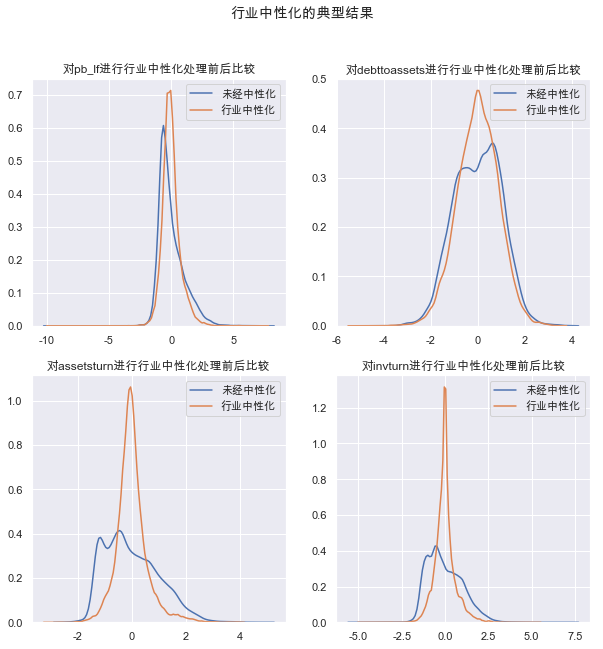

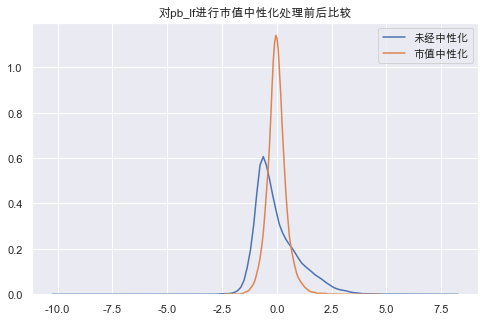

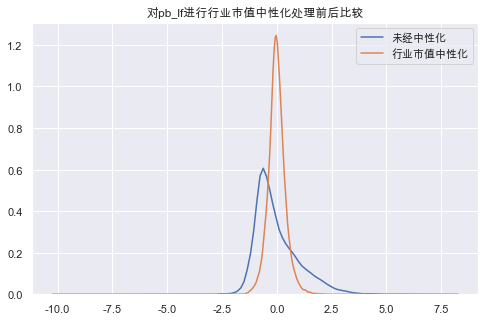

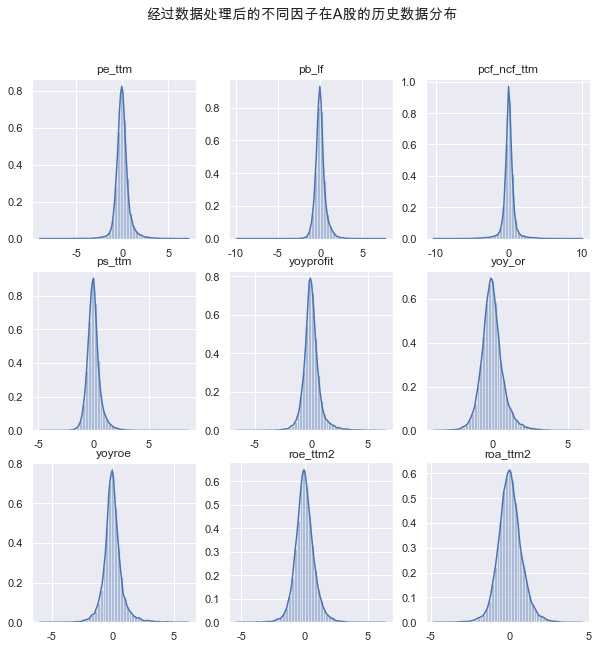

In [43]:
# %% [markdown]
# 那么，依据市现率因子选取出的股票必然对平均市现率高的行业有偏向，而我们希望投资组合中的行业尽可能分散，故我们希望对行业进行中性化。（同理，我们也希望对市值进行中性化。）
# 
# 中性化的主要做法就是通过回归得到一个与风险因子（行业因子、市值因子）**线性无关**的因子。（即线性回归后的残差项作为中性化后的新因子。）如此一来，中性化处理后的因子与风险因子之间的相关性就严格为零。
# 
# > 不过这样做中性化并不一定总能彻底地剔除因子的多余信息。因为线性回归要求两个前提假设：
# > 
# > - 因子之间线性相关
# > - 残差正态独立同分布
# >
# > 而在因子数据中这两个假设都不一定成立。（例如在[2.2去极值](##2.2去极值)步骤中密度过高的阈值就对数据的分布造成了破坏）
# 
# 但直观的说，根据[Brinson资产配置分析](https://www.investopedia.com/terms/a/attribution-analysis.asp)超额收益理论来看，如果投资组合中风险因子配置资产权重等于基准资产中其之权重，则做到了中性化。
# 
# 此处简便起见，我们依然采用线性回归作为中性化的处理方法。
# 
# 回归方式如下：
# 
# - 被解释变量：前述数据处理后的因子数据
# 
# - 解释变量：
# 
#   - 市值因子
#   - 行业因子（作为指示变量）
# 
# 最终回归方程的**残差**项即为中性化后的因子暴露。
# 
# （如下图，为选取四个因子指标进行行业中性化前后的结果，以展示中性化的一般结果👇，可以看出中性化导致分布更均匀、更接近均值）

# %%


def get_industry_exposure(factor_name):
    '''
    Parameter:
        factor_name: name of factors in Wind. (str)
    Return:
        industry exposure data. (pd.DataFrame)
    '''
    file_path = path + "/data/H3_Data/Neutralized2009_Data/industry_exposure_" + factor_name + ".csv"
    if os.path.isfile(file_path):
        industry_exposure = pd.read_csv(
            open(
                file_path,
                'r',
                encoding="utf-8"
            ),
            index_col=[0]
        )
    else:
        # Don't know why but different factor data \
        # has different hs300 stocks list,
        # so specify which factor is essential.
        hs300_stock_list = list(get_data(
            factor_name, 
            category="Processed2009",
            start_year='2009'
        ).columns)
        industry_exposure = pd.DataFrame(
            index=get_industry_list(),
            columns=hs300_stock_list
        )
        for stock in hs300_stock_list:
            try:
                industry_exposure.loc[
                    get_data("industry_sw").loc[
                        stock,
                        "INDUSTRY_SW"
                    ],
                    stock
                ] = 1
            except:
                continue
        industry_exposure.fillna(0, inplace=True)
        industry_exposure.to_csv(file_path)
    return industry_exposure

# %%


def neutralize(
    factor_name, 
    start_year="2009", 
    market_capital=True,
    industry=True
):
    '''
    Parameters:
        factor_name: name of factors in Wind. (str)
        market_capital: whether market-capital-neutralize or not. (bool)
        industry: whether industry-neutralize or not. (bool)
    Return:
        neutralized data. (pd.DataFrame)
    '''
    # don't know why but there's still nan.
    y = get_data(
        factor_name, 
        category="Processed"+start_year,
        start_year=start_year
    ).T
    industry_dummy = get_industry_exposure(factor_name).T.fillna(0)
    if market_capital:
        ln_market_capital = get_data(
            "val_lnmv", 
            category="Processed"+start_year,
            start_year=start_year
        ).T
        if industry:
            x = pd.concat([
                    ln_market_capital,
                    industry_dummy
                ], axis=1)
        else:
            x = ln_market_capital
    elif industry:
        x = industry_dummy
    
    x.fillna(0, inplace=True)
    y.fillna(0, inplace=True)
    y = y.loc[list(x.index), :]
    
    result = sm.OLS(y, x).fit()
    
    return result.resid.T

# %%


def plot_industry_neutralization(factor_name):
    '''
    Return: 
        a plot of neutralization comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.kdeplot(get_values(
        data=get_data(factor_name, category="Processed2009")
    ), label="未经中性化")
    sns.kdeplot(get_values(
        data=neutralize(
            factor_name,
            market_capital=False,
            industry=True
        )
    ), label="行业中性化")
    plt.legend()
    plt.title("对" + factor_name + "进行中性化处理前后比较")
    plt.savefig(path + "/output/H3_Plots/industry neutralization.png")

# %%


def overview_industry_neutralization(factor_list):
    '''
    Parameter:
        factor_list: list of factor names. (list)
    Return:
        save a 2*2 plot of neutralization comparison.
    '''
    plt.figure(figsize=(10, 10))
    for i in range(len(factor_list)):
        plt.subplot(int("22" + str(i+1)))
        sns.kdeplot(get_values(
            data=get_data(factor_list[i], category="Processed2009")
        ), label="未经中性化")
        sns.kdeplot(get_values(
            data=neutralize(
                factor_list[i],
                market_capital=False,
                industry=True
            )
        ), label="行业中性化")
        plt.legend()
        plt.title("对" + factor_list[i] + "进行行业中性化处理前后比较")
    plt.suptitle("行业中性化的典型结果")
    plt.savefig(path + "/output/H3_Plots/overview industry neutralization.png")

# %%
overview_industry_neutralization([
    "pb_lf",
    "debttoassets",
    "assetsturn",
    "invturn"
])

# %% [markdown]
# 对市值进行中性化也有类似的效果。（如下图为对"pb_lf"因子进行市值中性化的结果👇）

# %%


def plot_market_neutralization(factor_name):
    '''
    Return: 
        a plot of neutralization comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.kdeplot(get_values(
        data=get_data(factor_name, category="Processed2009")
    ), label="未经中性化")
    sns.kdeplot(get_values(
        data=neutralize(
            factor_name,
            market_capital=True,
            industry=False
        )
    ), label="市值中性化")
    plt.legend()
    plt.title("对" + factor_name + "进行市值中性化处理前后比较")
    plt.savefig(path + "/output/H3_Plots/market neutralization.png")

# %%
plot_market_neutralization("pb_lf")

# %% [markdown]
# 同样是"pb_lf"因子，同时对市值和行业进行中性化👇，效果也是相近的。

# %%


def plot_neutralization(factor_name):
    '''
    Return: 
        a plot of neutralization comparison.
    '''
    plt.figure(figsize=(8, 5))
    sns.kdeplot(get_values(
        data=get_data(factor_name, category="Processed2009")
    ), label="未经中性化")
    sns.kdeplot(get_values(
        data=neutralize(
            factor_name,
            market_capital=True,
            industry=True
        )
    ), label="行业市值中性化")
    plt.legend()
    plt.title("对" + factor_name + "进行行业市值中性化处理前后比较")
    plt.savefig(path + "/output/H3_Plots/industry & market neutralization.png")

# %%
plot_neutralization("pb_lf")

# %% [markdown]
# 
# > 数据处理中性化部分的：
# >
# > 数据保存在"H3_Data/Neutralized Data"文件夹里。
# 
# 最终经过所有因子数据处理步骤之后，原来的因子数据分布图变为了这样。
# 
# （经过所有数据处理步骤后的因子数据密度分布图一览👇）

# %%


def neutralize_and_store_data(start_year):
    '''
    Return:
        save industry neutralized data in
        "/data/H3_Data/Neutralized Data/".
    '''
    for factor in get_factors_list():
        file_path = path + "/data/H3_Data/Neutralized"+start_year+" Data/" + factor + ".csv"
        neutralized_data = neutralize(
            factor,start_year = start_year,
            market_capital=True,
            industry=True
        )
        neutralized_data.to_csv(file_path)
# %%
# neutralize_and_store_data('2009')
# neutralize_and_store_data('2007')
# %%


def overview_after_data_processing():
    # Get an overview of data after processing.
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(int("33" + str(i+1)))
        factor_name = get_factors_list()[i]
        sns.distplot(get_values(
            data=get_data(factor_name, category="Neutralized2009")
        ))
        plt.title(factor_name)
    plt.suptitle("经过数据处理后的不同因子在A股的历史数据分布")
    plt.savefig(path + "/output/H3_Plots/overview after data processing.png")


# %%
overview_after_data_processing()



/Users/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/Users/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/Users/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: 
Panel is

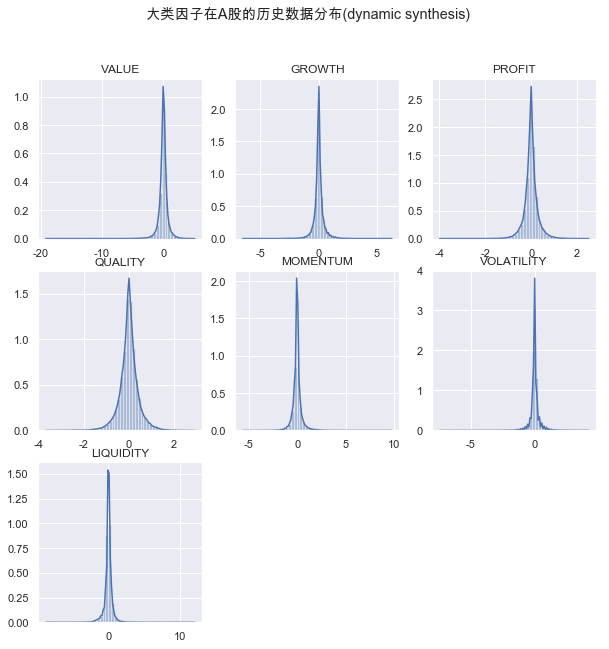

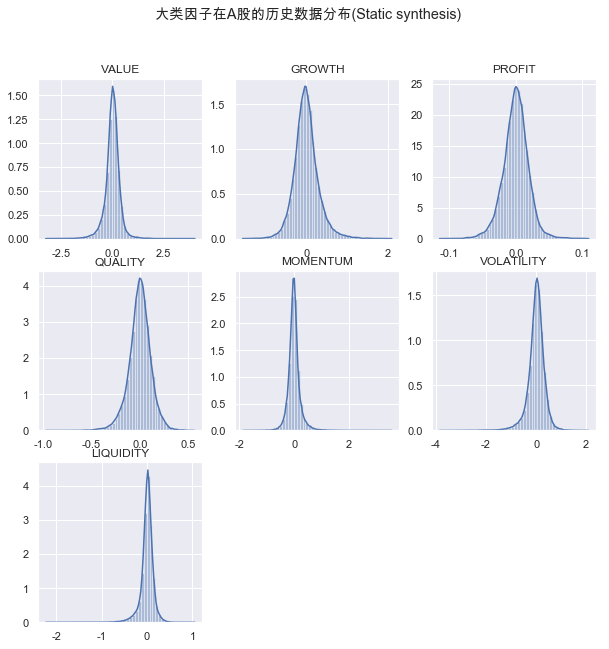

In [51]:
# %% [markdown]
# Step 3：大类因子合成
# 
# 前面两个步骤已经把风格因子的细分类因子数据经过数据处理并保存了下来，
# 这一步把细分类因子合成为大类因子。使得最终合成后只剩下：
# 
# - VALUE
# - GROWTH
# - PROFIT
# - QUALITY
# - VOLATILITY
# - MOMENTUM
# - LIQUIDITY
# 
# 这七个因子，我们的目标就是构建这七个因子的**纯因子组合**。
# 
# > 从这一步开始为方便提取数据，将数据从"pandas.DataFrame"
# 转换为"pandas.PanelData"。
# >
# > 数据格式为：
# >
# > - index: stock codes
# > - factor names
# >
# > 可以用以下方法提取特定时间的所有因子的所有股票数据：
# >
# > ```Python3
# > Large_factor.major_xs("20050131")
# > ```
# 
# 大类因子合成的方式是通过IC_IR加权合成。
# 
# > 大类因子合成部分的：
# >
# > 数据保存在"H3_Data/Composition Data"文件夹里。

# %%
# Turn dataframe into panel data.


def get_group_data(factor_list, start_year="2009"):
    datadict = {}
    for i in factor_list:
        # This should be the processed data.
        df = get_data(
            i, 
            category="Neutralized"+start_year,
            start_year=start_year
        )  
        datadict[i] = df
    panel = pd.Panel(datadict)
    return panel

# %%


class Large_factor_merge(object):
    def __init__(self, Large_factor):
        if Large_factor == 'VALUE':
            list = ["pe_ttm", "pb_lf", "pcf_ncf_ttm", "ps_ttm"]

        elif Large_factor == 'GROWTH':
            list = ["yoyprofit", "yoy_or", "yoyroe"]

        elif Large_factor == 'PROFIT':
            list = ["roe_ttm2", "roa_ttm2"]

        elif Large_factor == 'QUALITY':
            list = ["debttoassets", "assetsturn", "invturn"]

        elif Large_factor == 'MOMENTUM':
            list = ['pct_chg_1m', 'pct_chg_3m', 'pct_chg_6m']

        elif Large_factor == 'VOLATILITY':
            list = ["stdevry_3m", "stdevry_6m"]

        elif Large_factor == 'LIQUIDITY':
            list = ["tech_turnoverrate60", "tech_turnoverrate20"]

        self.data = get_group_data(list, "2007")
        self.data_2009 = get_group_data(list, "2009")
        self.Large_factor = Large_factor
    # Define the following function for you can read clearly 
    # and can acquire the data of every step.

    def Caculate_IC(self):
        stock_return = get_data(
            "pct_chg_1m", 
            category="raw",
            start_year="2007"
        )
        datadict = {}
        for i in self.data.items:
            df = self.data[i]
            IC = pd.DataFrame(columns=['IC_monthly'],
                              index=df.index[1:len(df)])
            IC_group = []
            for j in range(len(df)-1):
                cor = df.iloc[j].corr(stock_return.iloc[j+1])
                IC_group.append(cor)
            IC['IC_monthly'] = IC_group
            datadict[i] = IC
        IC_Large = pd.Panel(datadict)
        return IC_Large

    def Factors_merge_Static(self):
        IC_Large = self.Caculate_IC()
        weight_df = pd.DataFrame(
            columns=['weights'], 
            index=self.data.items
        )
        weight = []
        for i in IC_Large.items:
            df = IC_Large[i]
            IR = df.iloc[-24:, 0].mean()/df.iloc[-24:, 0].std()
            weight.append(IR)
        #weight = [x / sum(weight) for x in weight]  # adjust the sum of weight to 1.0
        weight_df['weights'] = weight
        weight = weight_df
        Factors_sum = pd.DataFrame(
            0, 
            columns=self.data_2009.minor_axis, 
            index=self.data_2009.major_axis
        )
        for i in self.data.items:
            df = self.data_2009[i]
            new_df = df * weight.loc[i, 'weights']
            Factors_sum = Factors_sum + new_df
        return Factors_sum

    def Factors_merge_dynamic(self):
        IC_Large = self.Caculate_IC()
        weight_df = pd.DataFrame(columns=IC_Large.major_axis[23:], index=IC_Large.items)
        for i in IC_Large.items:
            for j in range(23, len(IC_Large.major_axis)):
                df = IC_Large[i]
                IR = df.iloc[j - 23:j+1, 0].mean() / df.iloc[j - 23:j+1, 0].std()
                weight_df.loc[i, IC_Large.major_axis[j]] = IR
        #weight_df = weight_df.apply(lambda x: x / sum(x))
        weight = weight_df
        Factors_sum = pd.DataFrame(0, columns=self.data.minor_axis, index=weight.columns)
        for i in self.data_2009.items:
            df = self.data_2009[i]
            new_df = df.mul(weight.loc[i], axis=0)
            Factors_sum = Factors_sum + new_df
        return Factors_sum

# %%


def Merge_and_store_factors_Dynamic():
    Factor_dict = {}
    for i in ['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY']:
        Factor_data = Large_factor_merge(i).Factors_merge_dynamic()
        Factor_dict[i] = Factor_data
        file_path = path + "/data/H3_Data/Large_Factor_Dynamic_Data/" + i + ".csv"
        Factor_data.to_csv(file_path)
    Large_factor = pd.Panel(Factor_dict)
    return Large_factor
Large_factor_dynamic = Merge_and_store_factors_Dynamic()
# when you want to use one factor,you can edit'Large_factor[the name of the factor]'
# %%


def Merge_and_store_factors_Static():
    Factor_dict = {}
    for i in ['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY']:
        Factor_data = Large_factor_merge(i).Factors_merge_Static()
        Factor_dict[i] = Factor_data
        file_path = path + "/data/H3_Data/Large_Factor_Static_Data/" + i + ".csv"
        Factor_data.to_csv(file_path)
    Large_factor = pd.Panel(Factor_dict)
    return Large_factor
Large_factor_Static = Merge_and_store_factors_Static()

# %%

def get_Large_Factors(factor_name, type):
    category = "Large_Factor_" + type
    data = get_data(factor_name, category=category)
    return data

#%%


def overview_Large_factors(type):
    # Get an overview of data after processing.
    plt.figure(figsize = (10, 10))
    for i in range(7):
        plt.subplot(int("33" + str(i+1)))
        factor_name = get_large_factors_list()[i]
        sns.distplot(get_values(
            data = get_Large_Factors(factor_name,type)
        ))
        plt.title(factor_name)
    plt.suptitle("大类因子在A股的历史数据分布(" + type + ' synthesis)')
    plt.savefig(path + "/output/H3_Plots/Large Factors "+ type +".png")

# %% [markdown]
# 合成后的大类因子数据如下图，动态权重合成👇。

# %%
overview_Large_factors('dynamic')

# %% [markdown]
# 静态权重合成👇。

# %%
overview_Large_factors('Static')

# %% [markdown]
from sklearn import metrics

# %% 多元线性回归

def get_regression_data(time, next_time, type):
    # get 7(大类)+1（market）+28（行业）+1（return） data list for one stock
    data = pd.DataFrame(
        columns=[
            'return', 'VALUE', 'GROWTH', 'PROFIT', 
            'QUALITY', 'MOMENTUM', 'VOLATILITY', 'LIQUIDITY',
            'market'
        ]
    )
    
    for factor_name in [
        'VALUE', 'GROWTH', 'PROFIT', 
        'QUALITY', 'MOMENTUM', 'VOLATILITY', 'LIQUIDITY'
    ]:
        data[factor_name] = get_Large_Factors(factor_name, type).loc[time]
        
    data['market'] = get_data("val_lnmv", category="Processed", start_year="2009").T[time]
    data['return'] = get_data("pct_chg_1m", category="raw").loc[next_time]    
    
    industry_factor = get_industry_exposure('pb_lf').T    
    data = data.join(industry_factor)
    
    return data


def regression_model(y, X):
    model = sm.WLS(y, X)  # 加权最小二乘法 解决异方差性
    results = model.fit()
    # results.summary
    return {'beta': results.params, 'R^2': results.rsquared}


# %% 进行回归 获得因子收益矩阵和R^2
#
def run_regression(type):
    time_list = get_Large_Factors('VALUE', type).dropna(axis=0,how='any'). index
    param_df = pd.DataFrame(columns = time_list[1:])
    R2_temp = []

    for i in range(0,len(time_list)-1):
        regression_data = get_regression_data(time_list[i],time_list[i+1],type)
        regression_data = regression_data.dropna(axis=0,how='any') 
        y = regression_data['return']
        X = regression_data.iloc[:,1:]
        param = regression_model(y,X).get('beta')
        R2_temp = R2_temp + [regression_model(y,X).get('R^2')]
        param_df[time_list[i+1]] = param
        
    R2_list = pd.Series(R2_temp,index = time_list[1:])
    return {'factor_income': param_df, 'R^2': R2_list}

# run_regression('Static')==>进行回归

In [54]:
# %% 
# 方法一：估计因子预期收益，此处采用N=12的历史均值法

def estimated_factor_expected_income(type):
    F = run_regression(type).get('factor_income').T
    N = 12
    time_list = get_Large_Factors('VALUE', type).dropna(axis=0,how='any'). index
    F_predict = pd.DataFrame(columns=F.columns)
    #for i in range(N, len(time_list)):
    #    F_predict.loc[time_list[i]] = list(F.iloc[i-N:i].mean())
    F_predict.loc[time_list[len(time_list)-1]] = list(F.iloc[len(time_list)-1-N:len(time_list)].mean())
    return F_predict #因为无法获取未来时间日期值，此处返回的值为index值的下一个月的预期值
 
# 方法二：ARIMA
def estimated_factor_expected_income_ARIMA(type):
    F = run_regression(type).get('factor_income').T
#%% 收益预测模型
    
def load_of_factor(time, type): # 获得因子载荷矩阵 
    data = pd.DataFrame(
        columns=[
             'VALUE', 'GROWTH', 'PROFIT', 
            'QUALITY', 'MOMENTUM', 'VOLATILITY', 'LIQUIDITY',
            'market'
        ]
    )
    
    for factor_name in [
        'VALUE', 'GROWTH', 'PROFIT', 
        'QUALITY', 'MOMENTUM', 'VOLATILITY', 'LIQUIDITY'
    ]:
        data[factor_name] = get_Large_Factors(factor_name, type).loc[time]
        
    data['market'] = get_data("val_lnmv", category="Processed", start_year="2009").T[time] 
    
    industry_factor = get_industry_exposure('pb_lf').T    
    data = data.join(industry_factor)
            
    return data

def calculate_expected_return(type):
    f_predict = estimated_factor_expected_income(type)
    time_list = get_Large_Factors('VALUE', type).dropna(axis=0,how='any'). index
    X = load_of_factor(time_list[-1], type)
    r_predict = X.mul(f_predict,axis=1).T.sum()
    return r_predict
    
def evaluate_model(type):
    # 20190228的股票收益真实值
    real_return_data = pd.read_csv(open(path + "/data/H3_Data/Raw_Data/20190228pct_chg_1m.csv",'r',encoding="utf-8"), index_col=[0])
    predict_return_data = calculate_expected_return(type).to_frame()
    #stock code顺序不同 故合并
    data = real_return_data.join(predict_return_data)   
    ## 画图
    plt.plot(data)
    plt.plot(data[0]/data['return'])
    MSE = metrics.mean_squared_error(data['return'],data[0])
    RMSE = np.sqrt(MSE)
    return {'MSE': MSE, 'RMSE': RMSE}

# evaluate_model('Static')
# %% [markdown]
# # STEP 5

In [61]:
# %%
# 假设了之前很多回归的计算结果
from scipy.optimize import minimize
Factor_income =pd.DataFrame(-1+2*np.random.random((121,9)),columns=['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY','INDUSTRY','SIZE'],
                            index = get_data('ps_ttm', category="Neutralized").index)

Stock_predict = pd.DataFrame(-0.1+np.random.random((600,1))/3,columns=['yeild_forecast'],index = get_data('ps_ttm', category="Neutralized").columns)

Factor_predict = pd.DataFrame(-0.1+np.random.random((600,9))/3,columns=['VALUE','GROWTH','PROFIT','QUALITY','MOMENTUM','VOLATILITY','LIQUIDITY','INDUSTRY','SIZE'],index = get_data('ps_ttm', category="Neutralized").columns)
#每只股票的在不同时间点的残差，可以等于实际的股票收益率-预测的股票收益率
Stock_Residual = pd.DataFrame(-0.1+np.random.random((121,600))/5,columns = get_data('ps_ttm', category="Neutralized").columns,index = get_data('ps_ttm', category="Neutralized").index)




In [63]:
Factor_predict.head(10)

,VALUE,GROWTH,PROFIT,QUALITY,MOMENTUM,VOLATILITY,LIQUIDITY,INDUSTRY,SIZE
000001.SZ,-0.040579,-0.024894,0.168898,0.179872,0.009847,0.111338,0.003842,0.159587,-0.006537
000002.SZ,0.117866,0.164791,0.083577,0.170006,0.133075,-0.041499,-0.088035,0.115601,0.070296
000063.SZ,0.213917,-0.008096,-0.000438,0.118037,0.174767,-0.041530,0.059692,0.130328,-0.093018
000069.SZ,-0.035682,0.187351,0.068360,-0.039165,0.197143,0.124892,0.184927,0.115778,0.039431
000100.SZ,0.018453,-0.015530,0.224808,0.033855,-0.055981,-0.077734,-0.056462,0.170829,0.224358
000157.SZ,0.028087,0.013005,0.083875,0.043109,0.049535,0.184422,0.187274,0.093084,0.011132
000166.SZ,-0.017313,-0.077320,0.137394,0.180286,0.204379,0.086988,0.072970,0.232427,0.143640
000333.SZ,-0.051542,0.056380,0.162772,0.103294,0.132837,0.047096,0.150375,0.075685,0.101107
000338.SZ,-0.082901,0.070651,-0.093290,-0.053320,0.127559,-0.006028,-0.091504,-0.006243,0.212154
000402.SZ,0.224830,-0.067138,0.019259,0.098028,-0.082316,0.114384,0.207852,0.079154,0.128250


In [71]:
Large_Factors_list =  get_large_factors_list()

In [72]:
class Portfolio_Optimization(object):
    def __init__(self, Target_factors ,time_window,type):
        time_list = get_Large_Factors('VALUE', type).index
        self.Target_factors = Target_factors
        self.time_window = time_window
        self.type  = type
        self.Factor_income = estimated_factor_expected_income(self.type)
        self.Stock_predict = calculate_expected_return(self.type)
        self.Factor_predict = load_of_factor(time_list[-1], type)

    def Factor_covariance(self):
        factors = self.Factor_income.iloc[-self.time_window:]
        Cov = np.cov(factors.values.T)
        return Cov

    # 预测残差风险这一部分很复杂，用到半衰期权重和贝叶斯收缩，和波动性调整，其实不约束风险时，不用计算此项，先把框架搭起来，
    # 后面计算组合的夏普比率要用到组合方差，就要用到残差风险，后续研究我们再仔细研究这一部分具体怎么算
    def Trait_risk_forecast(self):
        Res = pd.DataFrame(-0.1+np.random.random((300,120))/5)
        return Res

    def optimization(self):
        Cov = self.Factor_covariance()
        Res = self.Trait_risk_forecast()
        yeild_T_1 = self.Stock_predict

        #非线性规划
        x0 = np.random.rand(300)
        x0 /= sum(x0)
        Non_target_factors = list(set(Large_Factors_list) ^ set(self.Target_factors))
        n = len(Non_target_factors)
        m = list(range(n))
        b = [0]*9
        b[0:n-1] = m
        # 此处我尝试了各种方法，用i遍历非目标纯因子然后生成条件，但是生成的条件在优化模型中没有被成功约束，最后只能全部写出来9个因子条件，
        # 对于目标纯因子，序数取的0，即条件是重复的非目标因子约束，这里的条件数据类型是tuple，tuple不能被增加，我试过先用list添加然后转为tuple,
        # 仍然没有被成功识别，如果有更简便的方法，欢迎提出
        # 最小化的函数
        func = lambda x: -(yeild_T_1 * np.mat(x).T).sum()[0]
        cons4 = ({'type': 'eq', 'fun': lambda x: x.sum() - 1},
                 {'type': 'ineq','fun': lambda x:(0.03-abs((self.Factor_predict[[Non_target_factors[b[0]]]]*np.mat(x).T).sum()[0]))},
                 {'type': 'ineq', 'fun': lambda x: (0.03 - abs((self.Factor_predict[[Non_target_factors[b[1]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq', 'fun': lambda x: (0.03 - abs((self.Factor_predict[[Non_target_factors[b[2]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq', 'fun': lambda x: (0.03 - abs((self.Factor_predict[[Non_target_factors[b[3]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq', 'fun': lambda x: (0.03 - abs((self.Factor_predict[[Non_target_factors[b[4]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((self.Factor_predict[[Non_target_factors[b[5]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((self.Factor_predict[[Non_target_factors[b[6]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((self.Factor_predict[[Non_target_factors[b[7]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((self.Factor_predict[[Non_target_factors[b[8]]]] * np.mat(x).T).sum()[0]))},
                 )
        # 如果要添加波动性约束，条件要改为以下，我写的是限制波动小于3%
        '''cons4 = ({'type': 'eq', 'fun': lambda x: x.sum() - 1},
                 {'type': 'ineq','fun': lambda x: (0.03 -((np.mat(Factor_predict).T*np.mat(x).T).T*Cov*(np.mat(Factor_predict).T*np.mat(x).T))[0,0]
                                    +(np.mat(x)*np.mat(Res)*np.mat(x).T))[0,0]},
                {'type': 'ineq', 'fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[0]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[1]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[2]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[3]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[4]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[5]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[6]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[7]]]] * np.mat(x).T).sum()[0]))},
                 {'type': 'ineq','fun': lambda x: (0.03 - abs((Factor_predict[[Non_target_factors[b[8]]]] * np.mat(x).T).sum()[0]))},
                 )'''
        c = (0,1)
        bnds = tuple([c]*300)#边界条件为0-1
        res = minimize(func, x0, method='SLSQP', constraints=cons4,bounds = bnds)
        Stock_weight = pd.DataFrame(res.x,columns=['Portfolio Weight'],index = Stock_predict.index)
        return  Stock_weight, -res.fun

# 目标纯因子为'VALUE','GROWTH','PROFIT'，使用历史时间段为过去32个月，仅对非目标纯因子偏离做约束条件，最大化收益，返回权重和组合收益
# 生成结果并输出权重和组合收益
def get_optimization_result(Target_factors ,time_window,type):
    [Stock_weight, Portfolio_Return] = Portfolio_Optimization(Target_factors ,time_window,type).optimization()
    Stock_weight['Portfolio Return'] = np.nan
    Stock_weight.iloc[0,-1] = Portfolio_Return
    Stock_weight.to_csv(path + "/data/H3_Data/Portfolio_result/ "+str(Target_factors)+"纯因子("+str(type)+").csv")

In [74]:
get_optimization_result(Large_Factors_list ,10,'Static')

/Users/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice
  del sys.path[0]


IndexError: list index out of range